In [1]:
import deepchem
deepchem.__version__

2023-02-21 23:31:11.113018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.7.1'

In [2]:
import deepchem as dc
import os

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from rdkit import Chem

from deepchem.molnet import load_pdbbind
from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer

In [3]:
f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
f2_num_atoms = 1000  # maximum number of atoms to consider in the protein
max_num_neighbors = 12  # maximum number of spatial neighbors for an atom

acf = AtomicConvFeaturizer(frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      neighbor_cutoff=4)

In [4]:
import os

data_folder = os.path.join(os.getenv('HOME'), 'datasets')


tasks, datasets, transformers = load_pdbbind(featurizer=acf,
                                             save_dir=data_folder,
                                             data_dir=data_folder,
                                             pocket=True,
                                             reload=False,
                                             set_name='core')

/home/kiddos/.local/lib/python3.8/site-packages/deepchem/feat/base_classes.py:213: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)


In [5]:
datasets

(<DiskDataset X.shape: (154, 9), y.shape: (154,), w.shape: (154,), ids: ['2xnb' '3acw' '1w4o' ... '1loq' '2zxd' '3bfu'], task_names: [0]>,
 <DiskDataset X.shape: (19, 9), y.shape: (19,), w.shape: (19,), ids: ['3gbb' '3myg' '3ov1' ... '3imc' '1q8u' '2iwx'], task_names: [0]>,
 <DiskDataset X.shape: (20, 9), y.shape: (20,), w.shape: (20,), ids: ['2xbv' '2weg' '3f3c' ... '2wbg' '1igj' '2xys'], task_names: [0]>)

In [7]:
class MyTransformer(dc.trans.Transformer):
    def transform_array(x, y, w, ids):
        kept_rows = x != None
        return x[kept_rows], y[kept_rows], w[kept_rows], ids[kept_rows],


filtered_datasets = [d.transform(MyTransformer) for d in datasets]
filtered_datasets

/tmp/ipykernel_2900456/2166065049.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  kept_rows = x != None
/tmp/ipykernel_2900456/2166065049.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  kept_rows = x != None
/tmp/ipykernel_2900456/2166065049.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  kept_rows = x != None


[<DiskDataset X.shape: (1, 154, 9), y.shape: (1, 154), w.shape: (1, 154), ids: ['2xnb' '3acw' '1w4o' ... '1loq' '2zxd' '3bfu'], task_names: [0]>,
 <DiskDataset X.shape: (1, 19, 9), y.shape: (1, 19), w.shape: (1, 19), ids: ['3gbb' '3myg' '3ov1' ... '3imc' '1q8u' '2iwx'], task_names: [0]>,
 <DiskDataset X.shape: (1, 20, 9), y.shape: (1, 20), w.shape: (1, 20), ids: ['2xbv' '2weg' '3f3c' ... '2wbg' '1igj' '2xys'], task_names: [0]>]

In [8]:
datasets

(<DiskDataset X.shape: (154, 9), y.shape: (154,), w.shape: (154,), ids: ['2xnb' '3acw' '1w4o' ... '1loq' '2zxd' '3bfu'], task_names: [0]>,
 <DiskDataset X.shape: (19, 9), y.shape: (19,), w.shape: (19,), ids: ['3gbb' '3myg' '3ov1' ... '3imc' '1q8u' '2iwx'], task_names: [0]>,
 <DiskDataset X.shape: (20, 9), y.shape: (20,), w.shape: (20,), ids: ['2xbv' '2weg' '3f3c' ... '2wbg' '1igj' '2xys'], task_names: [0]>)

In [9]:
train, val, test = datasets

In [10]:
acm = AtomicConvModel(n_tasks=1,
                      frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      batch_size=12,
                      layer_sizes=[32, 32, 16],
                      learning_rate=0.003,
                      )

2023-02-21 23:33:31.627218: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [11]:
losses, val_losses = [], []

max_epochs = 50

metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
step_cutoff = len(train)//12
def val_cb(model, step):
    if step%step_cutoff!=0:
        return
    val_losses.append(model.evaluate(val, metrics=[metric])['rms_score']**2)  # L2 Loss
    losses.append(model.evaluate(train, metrics=[metric])['rms_score']**2)  # L2 Loss


acm.fit(train, nb_epoch=max_epochs, max_checkpoints_to_keep=1, callbacks=[val_cb])

0.38988189697265624

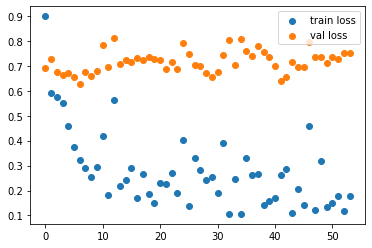

In [13]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right')

In [14]:
score = dc.metrics.Metric(dc.metrics.score_function.pearson_r2_score)
for tvt, ds in zip(['train', 'val', 'test'], datasets):
    print(tvt, acm.evaluate(ds, metrics=[score]))

train {'pearson_r2_score': 0.9361549541628259}
val {'pearson_r2_score': 0.29411563263001034}
test {'pearson_r2_score': 0.11119585663708585}


In [15]:
from deepchem.feat import RdkitGridFeaturizer

In [16]:
featurizer = RdkitGridFeaturizer()

tasks, datasets, transformers = load_pdbbind(featurizer=featurizer,
                                             save_dir=data_folder,
                                             data_dir=data_folder,
                                             pocket=True,
                                             reload=False,
                                             set_name='core')

datasets

(<DiskDataset X.shape: (154, 16, 16, 16, 8), y.shape: (154,), w.shape: (154,), ids: ['2zxd' '4des' '1n1m' ... '3pe2' '2cbj' '3mss'], task_names: [0]>,
 <DiskDataset X.shape: (19, 16, 16, 16, 8), y.shape: (19,), w.shape: (19,), ids: ['3cyx' '1u33' '2qmj' ... '2p4y' '3gy4' '3bkk'], task_names: [0]>,
 <DiskDataset X.shape: (20, 16, 16, 16, 8), y.shape: (20,), w.shape: (20,), ids: ['2cet' '4de2' '3dd0' ... '3pxf' '4djr' '2qbp'], task_names: [0]>)